C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4678956205065841 and num_layers=1
  warnings.warn(
C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14063490978424847 and num_layers=1
  warnings.warn(
C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropou

Training LSTM...
LSTM Metrics: {'MSE': 0.0007747735, 'MAE': 0.022223271, 'RMSE': 0.027834753, 'MAPE': 3.398972749710083, 'R2': 0.9525896310806274}
Training GRU...
GRU Metrics: {'MSE': 0.0013474198, 'MAE': 0.0295081, 'RMSE': 0.03670722, 'MAPE': 4.385893419384956, 'R2': 0.917547881603241}
Training Bi-LSTM...
Bi-LSTM Metrics: {'MSE': 0.00042718012, 'MAE': 0.015436135, 'RMSE': 0.020668335, 'MAPE': 2.387562394142151, 'R2': 0.9738597273826599}
Training GRU-Attention...
GRU-Attention Metrics: {'MSE': 0.001071941, 'MAE': 0.024697192, 'RMSE': 0.03274051, 'MAPE': 3.6245573312044144, 'R2': 0.9344051480293274}
Training LSTM-Attention...
LSTM-Attention Metrics: {'MSE': 0.005304858, 'MAE': 0.062143132, 'RMSE': 0.072834454, 'MAPE': 9.42397341132164, 'R2': 0.6753820180892944}
Training GRU-LSTM...
GRU-LSTM Metrics: {'MSE': 0.0011924232, 'MAE': 0.028203646, 'RMSE': 0.03453148, 'MAPE': 4.303523153066635, 'R2': 0.9270325303077698}

Model Evaluation Results:
                     MSE       MAE      RMSE    

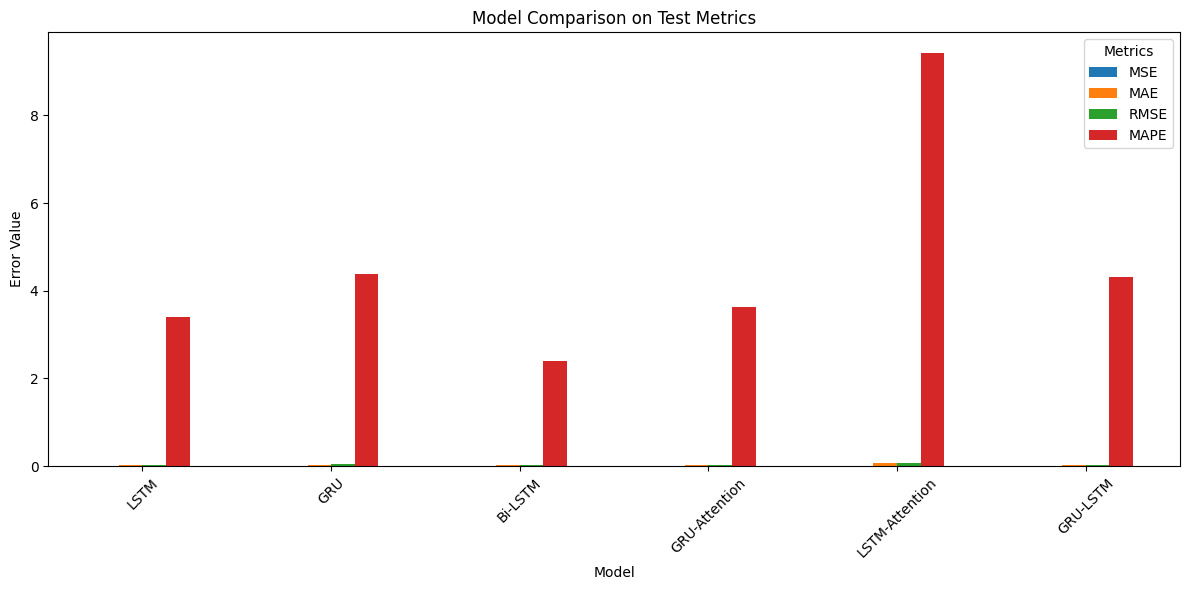

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# تنظیمات اولیه برای تولید نتایج قابل بازتولید
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 1. بارگذاری و پیش‌پردازش داده‌ها
data = pd.read_csv("Book1.csv")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values(by="Date")

# حذف ستون‌های غیرعددی و نرمال‌سازی داده‌ها
numeric_data = data.drop(columns=["Date"])
numeric_data = numeric_data[['Close'] + [col for col in numeric_data.columns if col != 'Close']]
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(numeric_data)

data[numeric_data.columns] = normalized_data

# تقسیم داده‌ها به سه بخش: آموزش، ولیدیشن و تست
train_data = data[(data["Date"].dt.year >= 2017) & (data["Date"].dt.year <= 2022)].drop(columns=["Date"]).values
val_data = data[data["Date"].dt.year == 2023].drop(columns=["Date"]).values
test_data = data[data["Date"].dt.year == 2024].drop(columns=["Date"]).values

# تعریف تابع برای ایجاد توالی‌های زمانی
def create_sequences(data, sequence_length=30):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data[i+sequence_length, 0]  # ستون "Close" به عنوان هدف
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 30
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# آماده‌سازی داده‌ها برای PyTorch
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. تعریف مدل‌های مختلف
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        return self.fc(gru_out[:, -1, :])

class GRUAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(GRUAttentionModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        attention_weights = torch.softmax(self.attention(gru_out), dim=1)
        context_vector = torch.sum(attention_weights * gru_out, dim=1)
        return self.fc(context_vector)

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        return self.fc(context_vector)

class LSTMGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMGRUModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.gru = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        gru_out, _ = self.gru(lstm_out)
        return self.fc(gru_out[:, -1, :])

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        return self.fc(bilstm_out[:, -1, :])

# 3. تابع آموزش و ارزیابی مدل‌ها
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    return model

def evaluate_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    predictions, targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch).squeeze()
            predictions.extend(preds.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())

    return np.array(predictions), np.array(targets)

# محاسبه معیارهای مختلف
from sklearn.metrics import mean_absolute_error, r2_score

def calculate_metrics(predictions, targets):
    mse = np.mean((predictions - targets) ** 2)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((targets - predictions) / targets)) * 100
    r2 = r2_score(targets, predictions)
    return {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2
    }

# 4. ارزیابی مدل‌ها
models = {
    "LSTM": (LSTMModel(input_dim=X_train.shape[2], hidden_dim=256, num_layers=1, dropout=0.4678956205065841), 0.002168276979669592),
    "GRU": (GRUModel(input_dim=X_train.shape[2], hidden_dim=32, num_layers=1, dropout=0.30883575663821067), 0.016030491965989343),
    "Bi-LSTM": (BiLSTMModel(input_dim=X_train.shape[2], hidden_dim=224, num_layers=1, dropout=0.14063490978424847), 0.00191084309168345),
    "GRU-Attention": (GRUAttentionModel(input_dim=X_train.shape[2], hidden_dim=160, num_layers=1, dropout=0.11142059611560115), 0.009706314256981331),
    "LSTM-Attention": (LSTMAttentionModel(input_dim=X_train.shape[2], hidden_dim=224, num_layers=3, dropout=0.4332642026284568), 0.0048610015241686315),
    "GRU-LSTM": (LSTMGRUModel(input_dim=X_train.shape[2], hidden_dim=224, num_layers=1, dropout=0.39357366644561154), 0.0003010755640891354)
}

results = {}

for name, (model, learning_rate) in models.items():
    print(f"Training {name}...")
    trained_model = train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=learning_rate)
    predictions, targets = evaluate_model(trained_model, test_loader)
    metrics = calculate_metrics(predictions, targets)
    results[name] = metrics
    print(f"{name} Metrics: {metrics}")

# 5. نمایش نتایج
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Results:")
print(results_df)

# 6. رسم نمودار مقایسه‌ای
results_df[["MSE", "MAE", "RMSE", "MAPE"]].plot(kind="bar", figsize=(12, 6))
plt.title("Model Comparison on Test Metrics")
plt.ylabel("Error Value")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()



C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4678956205065841 and num_layers=1
  warnings.warn(
C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30883575663821067 and num_layers=1
  warnings.warn(
C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14063490978424847 and num_layers=1
  warnings.warn(
C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so

Training LSTM...
LSTM Metrics: {'MSE': 0.0007747735, 'MAE': 0.022223271, 'RMSE': 0.027834753, 'MAPE': 3.398972749710083, 'R2': 0.9525896310806274}
Training GRU...
GRU Metrics: {'MSE': 0.0019372806, 'MAE': 0.035613004, 'RMSE': 0.04401455, 'MAPE': 5.238847807049751, 'R2': 0.8814527988433838}
Training Bi-LSTM...
Bi-LSTM Metrics: {'MSE': 0.00042718012, 'MAE': 0.015436135, 'RMSE': 0.020668335, 'MAPE': 2.387562394142151, 'R2': 0.9738597273826599}
Training GRU-Attention...
GRU-Attention Metrics: {'MSE': 0.001071941, 'MAE': 0.024697192, 'RMSE': 0.03274051, 'MAPE': 3.6245573312044144, 'R2': 0.9344051480293274}
Training LSTM-Attention...
LSTM-Attention Metrics: {'MSE': 0.005304858, 'MAE': 0.062143132, 'RMSE': 0.072834454, 'MAPE': 9.42397341132164, 'R2': 0.6753820180892944}
Training GRU-LSTM...
GRU-LSTM Metrics: {'MSE': 0.0011924232, 'MAE': 0.028203646, 'RMSE': 0.03453148, 'MAPE': 4.303523153066635, 'R2': 0.9270325303077698}

Model Evaluation Results:
                     MSE       MAE      RMSE 

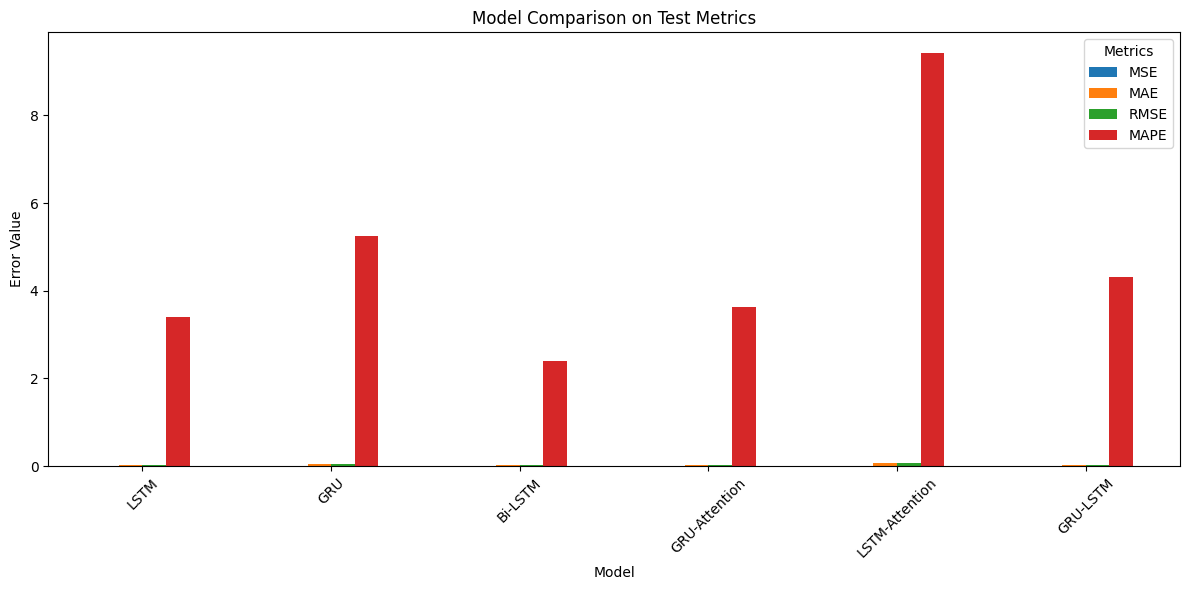

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# تنظیمات اولیه برای تولید نتایج قابل بازتولید
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 1. بارگذاری و پیش‌پردازش داده‌ها
data = pd.read_csv("Book1.csv")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values(by="Date")

# حذف ستون‌های غیرعددی و نرمال‌سازی داده‌ها
numeric_data = data.drop(columns=["Date"])
numeric_data = numeric_data[['Close'] + [col for col in numeric_data.columns if col != 'Close']]
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(numeric_data)

data[numeric_data.columns] = normalized_data

# تقسیم داده‌ها به سه بخش: آموزش، ولیدیشن و تست
train_data = data[(data["Date"].dt.year >= 2017) & (data["Date"].dt.year <= 2022)].drop(columns=["Date"]).values
val_data = data[data["Date"].dt.year == 2023].drop(columns=["Date"]).values
test_data = data[data["Date"].dt.year == 2024].drop(columns=["Date"]).values

# تعریف تابع برای ایجاد توالی‌های زمانی
def create_sequences(data, sequence_length=30):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data[i+sequence_length, 0]  # ستون "Close" به عنوان هدف
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 30
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# آماده‌سازی داده‌ها برای PyTorch
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. تعریف مدل‌های مختلف
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        return self.fc(gru_out[:, -1, :])

class GRUAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(GRUAttentionModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        attention_weights = torch.softmax(self.attention(gru_out), dim=1)
        context_vector = torch.sum(attention_weights * gru_out, dim=1)
        return self.fc(context_vector)

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        return self.fc(context_vector)

class LSTMGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMGRUModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.gru = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        gru_out, _ = self.gru(lstm_out)
        return self.fc(gru_out[:, -1, :])

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        return self.fc(bilstm_out[:, -1, :])

# 3. تابع آموزش و ارزیابی مدل‌ها
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    return model

def evaluate_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    predictions, targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch).squeeze()
            predictions.extend(preds.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())

    return np.array(predictions), np.array(targets)

# محاسبه معیارهای مختلف
from sklearn.metrics import mean_absolute_error, r2_score

def calculate_metrics(predictions, targets):
    mse = np.mean((predictions - targets) ** 2)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((targets - predictions) / targets)) * 100
    r2 = r2_score(targets, predictions)
    return {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2
    }

# 4. ارزیابی مدل‌ها
models = {
    "LSTM": (LSTMModel(input_dim=X_train.shape[2], hidden_dim=256, num_layers=1, dropout=0.4678956205065841), 0.002168276979669592),
    "GRU": (GRUModel(input_dim=X_train.shape[2], hidden_dim=32, num_layers=1, dropout=0.30883575663821067), 0.016030491965989343),
    "Bi-LSTM": (BiLSTMModel(input_dim=X_train.shape[2], hidden_dim=224, num_layers=1, dropout=0.14063490978424847), 0.00191084309168345),
    "GRU-Attention": (GRUAttentionModel(input_dim=X_train.shape[2], hidden_dim=160, num_layers=1, dropout=0.11142059611560115), 0.009706314256981331),
    "LSTM-Attention": (LSTMAttentionModel(input_dim=X_train.shape[2], hidden_dim=224, num_layers=3, dropout=0.4332642026284568), 0.0048610015241686315),
    "GRU-LSTM": (LSTMGRUModel(input_dim=X_train.shape[2], hidden_dim=224, num_layers=1, dropout=0.39357366644561154), 0.0003010755640891354)
}

results = {}

for name, (model, learning_rate) in models.items():
    print(f"Training {name}...")
    trained_model = train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=learning_rate)
    predictions, targets = evaluate_model(trained_model, test_loader)
    metrics = calculate_metrics(predictions, targets)
    results[name] = metrics
    print(f"{name} Metrics: {metrics}")

# 5. نمایش نتایج
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Results:")
print(results_df)

# 6. رسم نمودار مقایسه‌ای
results_df[["MSE", "MAE", "RMSE", "MAPE"]].plot(kind="bar", figsize=(12, 6))
plt.title("Model Comparison on Test Metrics")
plt.ylabel("Error Value")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()



C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4678956205065841 and num_layers=1
  warnings.warn(
C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30883575663821067 and num_layers=1
  warnings.warn(
C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14063490978424847 and num_layers=1
  warnings.warn(
C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so

Training LSTM...
LSTM Metrics: {'MSE': 0.0007747735, 'MAE': 0.022223271, 'RMSE': 0.027834753, 'MAPE': 3.398972749710083, 'R2': 0.9525896310806274}
Training GRU...
GRU Metrics: {'MSE': 0.0019372806, 'MAE': 0.035613004, 'RMSE': 0.04401455, 'MAPE': 5.238847807049751, 'R2': 0.8814527988433838}
Training Bi-LSTM...
Bi-LSTM Metrics: {'MSE': 0.00042718012, 'MAE': 0.015436135, 'RMSE': 0.020668335, 'MAPE': 2.387562394142151, 'R2': 0.9738597273826599}
Training GRU-Attention...
GRU-Attention Metrics: {'MSE': 0.001071941, 'MAE': 0.024697192, 'RMSE': 0.03274051, 'MAPE': 3.6245573312044144, 'R2': 0.9344051480293274}
Training LSTM-Attention...
LSTM-Attention Metrics: {'MSE': 0.005304858, 'MAE': 0.062143132, 'RMSE': 0.072834454, 'MAPE': 9.42397341132164, 'R2': 0.6753820180892944}
Training GRU-LSTM...
GRU-LSTM Metrics: {'MSE': 0.0011924232, 'MAE': 0.028203646, 'RMSE': 0.03453148, 'MAPE': 4.303523153066635, 'R2': 0.9270325303077698}

Model Evaluation Results:
                     MSE       MAE      RMSE 

<Figure size 1000x600 with 0 Axes>

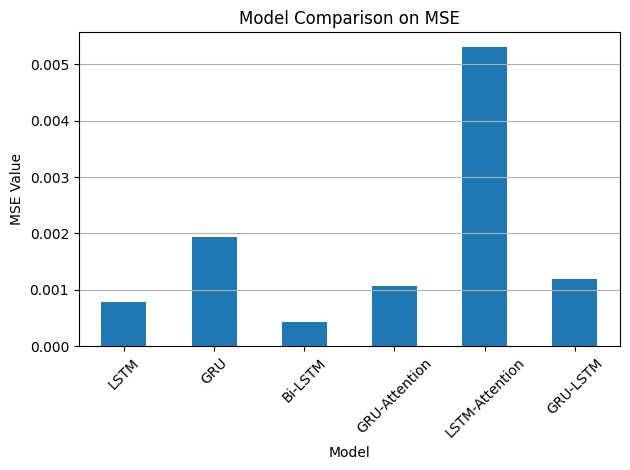

<Figure size 1000x600 with 0 Axes>

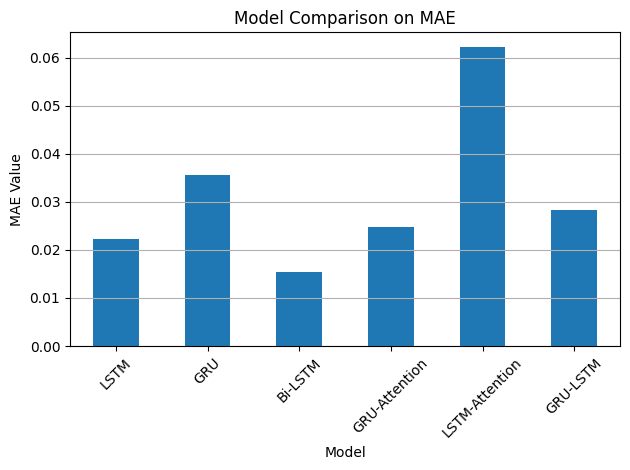

<Figure size 1000x600 with 0 Axes>

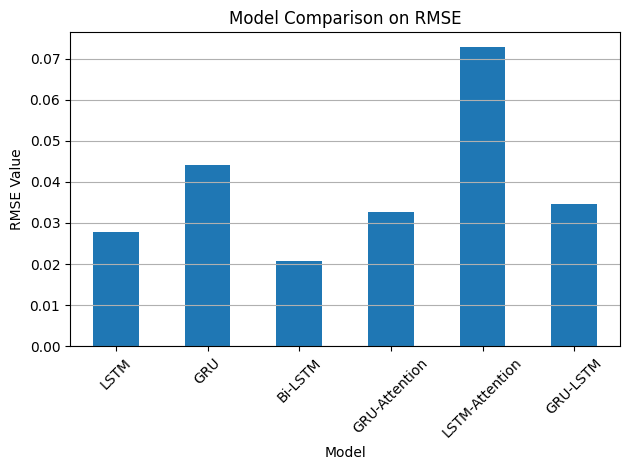

<Figure size 1000x600 with 0 Axes>

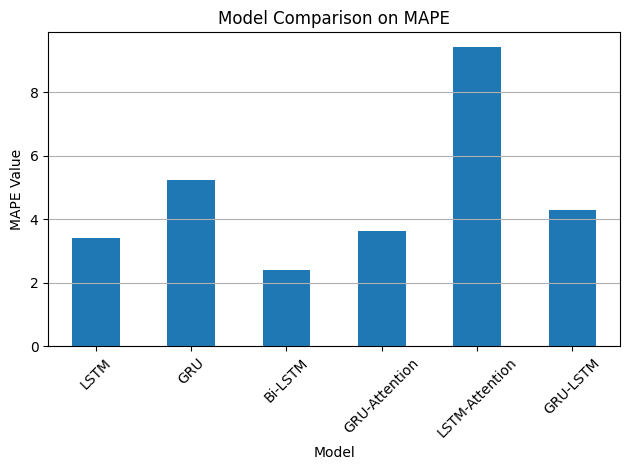

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# تنظیمات اولیه برای تولید نتایج قابل بازتولید
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 1. بارگذاری و پیش‌پردازش داده‌ها
data = pd.read_csv("Book1.csv")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values(by="Date")

# حذف ستون‌های غیرعددی و نرمال‌سازی داده‌ها
numeric_data = data.drop(columns=["Date"])
numeric_data = numeric_data[['Close'] + [col for col in numeric_data.columns if col != 'Close']]
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(numeric_data)

data[numeric_data.columns] = normalized_data

# تقسیم داده‌ها به سه بخش: آموزش، ولیدیشن و تست
train_data = data[(data["Date"].dt.year >= 2017) & (data["Date"].dt.year <= 2022)].drop(columns=["Date"]).values
val_data = data[data["Date"].dt.year == 2023].drop(columns=["Date"]).values
test_data = data[data["Date"].dt.year == 2024].drop(columns=["Date"]).values

# تعریف تابع برای ایجاد توالی‌های زمانی
def create_sequences(data, sequence_length=30):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data[i+sequence_length, 0]  # ستون "Close" به عنوان هدف
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 30
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# آماده‌سازی داده‌ها برای PyTorch
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. تعریف مدل‌های مختلف
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        return self.fc(gru_out[:, -1, :])

class GRUAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(GRUAttentionModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        attention_weights = torch.softmax(self.attention(gru_out), dim=1)
        context_vector = torch.sum(attention_weights * gru_out, dim=1)
        return self.fc(context_vector)

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        return self.fc(context_vector)

class LSTMGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMGRUModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.gru = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        gru_out, _ = self.gru(lstm_out)
        return self.fc(gru_out[:, -1, :])

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        return self.fc(bilstm_out[:, -1, :])

# 3. تابع آموزش و ارزیابی مدل‌ها
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    return model

def evaluate_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    predictions, targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch).squeeze()
            predictions.extend(preds.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())

    return np.array(predictions), np.array(targets)

# محاسبه معیارهای مختلف
from sklearn.metrics import mean_absolute_error, r2_score

def calculate_metrics(predictions, targets):
    mse = np.mean((predictions - targets) ** 2)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((targets - predictions) / targets)) * 100
    r2 = r2_score(targets, predictions)
    return {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2
    }

# 4. ارزیابی مدل‌ها
models = {
    "LSTM": (LSTMModel(input_dim=X_train.shape[2], hidden_dim=256, num_layers=1, dropout=0.4678956205065841), 0.002168276979669592),
    "GRU": (GRUModel(input_dim=X_train.shape[2], hidden_dim=32, num_layers=1, dropout=0.30883575663821067), 0.016030491965989343),
    "Bi-LSTM": (BiLSTMModel(input_dim=X_train.shape[2], hidden_dim=224, num_layers=1, dropout=0.14063490978424847), 0.00191084309168345),
    "GRU-Attention": (GRUAttentionModel(input_dim=X_train.shape[2], hidden_dim=160, num_layers=1, dropout=0.11142059611560115), 0.009706314256981331),
    "LSTM-Attention": (LSTMAttentionModel(input_dim=X_train.shape[2], hidden_dim=224, num_layers=3, dropout=0.4332642026284568), 0.0048610015241686315),
    "GRU-LSTM": (LSTMGRUModel(input_dim=X_train.shape[2], hidden_dim=224, num_layers=1, dropout=0.39357366644561154), 0.0003010755640891354)
}

results = {}

for name, (model, learning_rate) in models.items():
    print(f"Training {name}...")
    trained_model = train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=learning_rate)
    predictions, targets = evaluate_model(trained_model, test_loader)
    metrics = calculate_metrics(predictions, targets)
    results[name] = metrics
    print(f"{name} Metrics: {metrics}")

# 5. نمایش نتایج
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Results:")
print(results_df)

import matplotlib.pyplot as plt

# رسم نمودارهای جداگانه برای هر معیار
metrics = ["MSE", "MAE", "RMSE", "MAPE"]
for metric in metrics:
    plt.figure(figsize=(10, 6))
    results_df[[metric]].plot(kind="bar", legend=False)
    plt.title(f"Model Comparison on {metric}")
    plt.ylabel(f"{metric} Value")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

